# Simple python Machine Learning Clustering example

author: Michael O'Donnell, 10/15/19

### First, import libraries for web scraping

In [29]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd

### scrape all the guards in the NBA, so we have a dataset to work with

In [30]:
# URL of page we will scrape
url = "https://www.basketball-reference.com/play-index/psl_finder.cgi?request=1&match=combined&type=per_game&per_minute_base=36&per_poss_base=100&season_start=1&season_end=-1&lg_id=NBA&age_min=0&age_max=99&is_active=Y&is_playoffs=N&height_min=0&height_max=99&year_min=2017&year_max=2019&birth_country_is=Y&as_comp=gt&as_val=0&pos_is_g=Y&order_by=ws"

# get the HTML from the given URL
html = urlopen(url)
soup = BeautifulSoup(html)

In [31]:
# get the column headers
soup.findAll('tr', limit=2)

# extract text we need into a list, important to use [1] here
headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]

# exclude the rank column, print the column headers
headers = headers[1:]
headers

['Player',
 'From',
 'To',
 'Tm',
 'Lg',
 'WS',
 'G',
 'GS',
 'MP',
 'FG',
 'FGA',
 '2P',
 '2PA',
 '3P',
 '3PA',
 'FT',
 'FTA',
 'ORB',
 'DRB',
 'TRB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS',
 'FG%',
 '2P%',
 '3P%',
 'eFG%',
 'FT%',
 'TS%']

In [47]:
# remove the first row two rows
rows = soup.findAll('tr')[2:]
player_stats = [[td.getText() for td in rows[i].findAll('td')]
            for i in range(len(rows))]

In [48]:
player_stats = pd.DataFrame(player_stats, columns = headers)

# drop NaN values
player_stats = player_stats.dropna()
player_stats.head(5)

,Player,From,To,Tm,Lg,WS,G,GS,MP,FG,...,BLK,TOV,PF,PTS,FG%,2P%,3P%,eFG%,FT%,TS%
0,James Harden,2017,2019,HOU,NBA,45.6,231,231,36.2,9.4,...,0.6,5.0,2.7,31.9,.443,.530,.361,.536,.861,.616
1,Damian Lillard,2017,2019,POR,NBA,35.1,228,228,36.0,8.6,...,0.4,2.7,1.8,26.5,.443,.497,.366,.519,.908,.589
2,Stephen Curry,2017,2019,GSW,NBA,31.3,199,199,33.2,8.7,...,0.3,2.9,2.3,26.3,.476,.546,.424,.598,.911,.643
3,Russell Westbrook,2017,2019,OKC,NBA,29.9,234,234,35.7,9.4,...,0.4,4.9,2.7,26.8,.433,.475,.315,.474,.766,.529
4,Chris Paul,2017,2019,TOT,NBA,27.4,177,177,31.8,5.9,...,0.2,2.4,2.4,17.5,.453,.511,.381,.539,.892,.594


In [49]:
# only keep the columns we need (for simplicity)
player_stats = player_stats[['Player', 'PTS', '3P', 'AST', 'TRB', 'STL', 'BLK']]

# set index as player name
player_stats = player_stats.set_index('Player')
player_stats.head(5)

,PTS,3P,AST,TRB,STL,BLK
Player,,,,,,
James Harden,31.9,3.9,9.2,6.8,1.8,0.6
Damian Lillard,26.5,3.0,6.5,4.7,1.0,0.4
Stephen Curry,26.3,4.5,6.0,4.9,1.6,0.3
Russell Westbrook,26.8,1.8,10.4,10.6,1.8,0.4
Chris Paul,17.5,2.2,8.4,5.0,1.9,0.2


### Now, use unsupervised learning to cluster the guards into groups based on stats

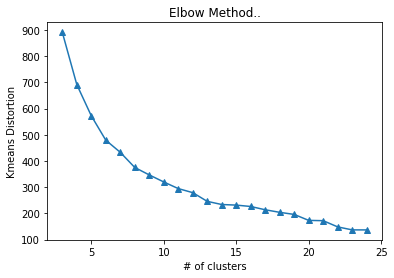

In [50]:
# import kmeans library from scikit learn and matplotlib
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# figure out the appropriate number of clusters for the data
# btw, this is the Elbow Method!
distortions = []
for i in range(3, 25):
    kmeans = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    kmeans.fit(player_stats)
    distortions.append(kmeans.inertia_)

# plot
plt.plot(range(3, 25), distortions, marker='^')
plt.xlabel('# of clusters')
plt.ylabel('Kmeans Distortion')
plt.title('Elbow Method..')
plt.show()

## Looks like 15 clusters is approriate, implement final method with k=15

In [60]:
kmeans = KMeans(
    n_clusters=15, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
player_kmeans = kmeans.fit_predict(player_stats)

In [61]:
# set the cluster as a column in the pandas dataframe
player_stats['cluster'] = player_kmeans
player_stats.head(5)

,PTS,3P,AST,TRB,STL,BLK,cluster
Player,,,,,,,
James Harden,31.9,3.9,9.2,6.8,1.8,0.6,4
Damian Lillard,26.5,3.0,6.5,4.7,1.0,0.4,0
Stephen Curry,26.3,4.5,6.0,4.9,1.6,0.3,0
Russell Westbrook,26.8,1.8,10.4,10.6,1.8,0.4,4
Chris Paul,17.5,2.2,8.4,5.0,1.9,0.2,7


## Print players in cluster 0

In [72]:
player_stats[player_stats.cluster == 0][['PTS', '3P', 'AST', 'TRB', 'STL', 'BLK']]

,PTS,3P,AST,TRB,STL,BLK
Player,,,,,,
Damian Lillard,26.5,3.0,6.5,4.7,1.0,0.4
Stephen Curry,26.3,4.5,6.0,4.9,1.6,0.3
Kyrie Irving,24.5,2.6,6.0,4.0,1.3,0.4
Kemba Walker,23.7,3.0,5.7,3.8,1.2,0.3
Bradley Beal,23.8,2.6,4.5,4.2,1.2,0.5
Isaiah Thomas,23.2,2.6,5.2,2.4,0.8,0.1
Devin Booker,24.3,2.2,4.9,3.9,0.9,0.2


## Print players in cluster 1

In [84]:
player_stats[player_stats.cluster == 1][['PTS', '3P', 'AST', 'TRB', 'STL', 'BLK']]

,PTS,3P,AST,TRB,STL,BLK
Player,,,,,,
Raymond Felton,6.4,0.8,2.3,2.1,0.6,0.2
Pat Connaughton,5.3,0.9,1.3,2.6,0.3,0.3
Shabazz Napier,7.6,1.0,2.0,1.8,0.8,0.2
Devin Harris,7.2,1.0,2.0,1.8,0.6,0.2
Quinn Cook,7.4,1.1,1.9,2.0,0.3,0.0
Malik Beasley,7.2,1.2,0.8,1.7,0.5,0.1
Justin Anderson,5.9,0.7,0.7,2.6,0.5,0.3
Langston Galloway,7.6,1.6,1.1,2.0,0.6,0.1
Norman Powell,7.5,0.9,1.3,2.1,0.6,0.2
